In [1]:
import tensorflow as tf
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[4:7], device_type = 'GPU' )

### 1. 获取所有图像、标签的路径：

In [3]:
image_path = glob.glob( '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/*.jpg' )
label_path = glob.glob( '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/*.png' )

In [4]:
# 抽查是否对应：不对应！！
image_path[123:125], label_path[123:125]

(['/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_228.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_230.jpg'],
 ['/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Abyssinian_220.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Abyssinian_221.png'])

In [5]:
# 排序：
image_path.sort( key = lambda x:x.split('/')[-1].split('.')[0].split('_')[-1] )
label_path.sort( key = lambda x:x.split('/')[-1].split('.')[0].split('_')[-1] )
# 再抽查：
image_path[1029:1033], label_path[1029:1033]

(['/home/gaoboyu/学习数据集/图片定位与分割数据集/images/beagle_125.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Bengal_125.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Birman_125.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Bombay_125.jpg'],
 ['/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/beagle_125.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Bengal_125.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Birman_125.png',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/trimaps/Bombay_125.png'])

In [6]:
len(image_path), len(label_path)

(7390, 7390)

### 2. 创建、划分数据集：

In [7]:
dataset = tf.data.Dataset.from_tensor_slices( (image_path, label_path) )

In [8]:
# 划分训练、测试集
test_count = int( len(image_path)*0.2 )
train_count = len(image_path) - test_count

train_dataset = dataset.skip(test_count)  # 跳过前这么多数据
test_dataset = dataset.take(test_count)   # 取前面这么多数据

### 3. 文件预处理函数：解码、归一化、尺寸统一！

In [9]:
# 文件读取 + 解码函数：原图是jpg，标签图是png
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)  # 记得加通道，否则是None！
    return img

def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [10]:
# 预处理函数：
def normal_image(image, label):
    # 对原图的处理：转换数据类型 + 归一化[-1,1]
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1
    # 对标签图的处理：它的取值范围是[1,2,3]，但习惯于从0开始[0,1,2]！故都减去1
    label = label - 1
    return image, label

In [11]:
# 总加载函数：
new_height = 224
new_weight = 224

def load_image( image_path, label_path ):
    # 对原图的处理：
    image = read_jpg(image_path)
    image = tf.image.resize(image, (new_height, new_weight))  # 尺寸统一
    # 对标签图的处理：
    label = read_png(label_path)
    label = tf.image.resize(label, (new_height, new_weight))  # 尺寸统一
    
    return normal_image(image, label)

In [12]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_image, num_parallel_calls = AUTOTUNE )
test_dataset = test_dataset.map( load_image, num_parallel_calls = AUTOTUNE )

In [13]:
# 最后的乱序（让每个epoch的训练，看到的图像顺序不一样！）、batch划分：
BATCH_SIZE = 32  # 跟显存有关！
train_dataset = train_dataset.shuffle(train_count).repeat().batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
# 查看最后的数据：
train_dataset, test_dataset

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


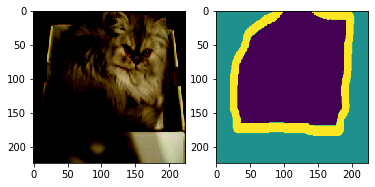

In [15]:
# 画图最后查看一下：从tf.data.Dataset拿出的数据，都是Tensor的！而matplotlib中的绘图必须是array的！
for image, label in train_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow( image[0].numpy() )
    plt.subplot(1,2,2)
    plt.imshow( label[0].numpy().reshape( (224,224) ) )

### 4. 使用预训练网络来搭建：获得多个中间层的输出！

In [16]:
conv_base = tf.keras.applications.VGG16( weights = 'imagenet', input_shape = (new_height, new_weight,3), include_top = False )

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# 用一个“多输出网络”来汇聚所有的用来跳接的层：
layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block2_conv2',
    'block5_pool'  # 最后的输出层out
]

# 把这些层名依次提取出来：
layers_output = [ conv_base.get_layer(layer_name).output for layer_name in layer_names ]

# 构建多输出网络：就是普通的多输出网络操作！
multi_out_model = tf.keras.models.Model(
    inputs = conv_base.input,
    outputs = layers_output
)

In [19]:
# 这些用来跳接的层，都是用已提取好的信息，即这些层是不可训练的！
multi_out_model.trainable = False

### 5. FCN搭建：网络后半部分

In [20]:
inputs = tf.keras.layers.Input( shape = (224,224,3) )

In [21]:
out_block5_conv3, out_block4_conv3, out_block3_conv3, out_block2_conv2, out = multi_out_model(inputs)
# 查看一下各自的形状：
out.shape, out_block5_conv3, out_block4_conv3, out_block3_conv3, out_block2_conv2

(TensorShape([None, 7, 7, 512]),
 <tf.Tensor 'model/Identity:0' shape=(None, 14, 14, 512) dtype=float32>,
 <tf.Tensor 'model/Identity_1:0' shape=(None, 28, 28, 512) dtype=float32>,
 <tf.Tensor 'model/Identity_2:0' shape=(None, 56, 56, 256) dtype=float32>,
 <tf.Tensor 'model/Identity_3:0' shape=(None, 112, 112, 128) dtype=float32>)

In [22]:
# 1. 对out层进行上采样，形成(14,14,512)
x1 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same', activation = 'relu' )(out)
print( x1.shape )

# 再加一层卷积提取特征：
x1 = tf.keras.layers.Conv2D(512, 3, strides=(1,1), padding='same', activation='relu')(x1)
print(x1)

(None, 14, 14, 512)
Tensor("conv2d/Identity:0", shape=(None, 14, 14, 512), dtype=float32)


In [23]:
# 2. 第一次跳接：x1和out_block5_conv3直接对应位置的元素的和
x2 = tf.add(x1, out_block5_conv3)
x2.shape

TensorShape([None, 14, 14, 512])

In [24]:
# 3. 对x2层进行上采样，形成(28,28,512)；然后和out_block4_conv3合并：
x3 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same', activation='relu')(x2)
# 加一层卷积：
x3 = tf.keras.layers.Conv2D(512, 3, strides=(1,1), padding='same', activation='relu')(x3)
# 把x3和out_block4_conv3合并
x4 = tf.add(x3, out_block4_conv3)
x4.shape

TensorShape([None, 28, 28, 512])

In [25]:
# 4. 对x4层进行上采样，形成(56,56,256)；然后和out_block3_conv3合并：
x5 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu')(x4)
# 加一层卷积：
x5 = tf.keras.layers.Conv2D(256, 3, strides=(1,1), padding='same', activation='relu')(x5)
# 把x5和out_block4_conv3合并
x6 = tf.add(x5, out_block3_conv3)
x6.shape

TensorShape([None, 56, 56, 256])

In [26]:
# 5. 对x6层进行上采样，形成(112,112,128)；然后和out_block2_conv2合并：
x7 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu')(x6)
# 加一层卷积：
x7 = tf.keras.layers.Conv2D(128, 3, strides=(1,1), padding='same', activation='relu')(x7)
# 把x5和out_block4_conv3合并
x8 = tf.add(x7, out_block2_conv2)
x8.shape

TensorShape([None, 112, 112, 128])

In [27]:
# 6 最后只用把x8层上采样，形成(224,224,3)即可：多分类，用softmax！
x9 = tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='softmax')(x8)
x9.shape

TensorShape([None, 224, 224, 3])

In [28]:
# （后半部分）模型创建：
model = tf.keras.models.Model( inputs = inputs, outputs = x9 )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 14, 14, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 14, 14, 512)  2359808     model[1][4]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 512)  2359808     conv2d_transpose[0][0]           
____________________________________________________________________________________________

In [29]:
# 模型编译：
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [30]:
# 模型训练：
EPOCHS = 5
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    steps_per_epoch = train_count // BATCH_SIZE,
    validation_data = test_dataset,
    validation_steps = test_count // BATCH_SIZE
)

Epoch 1/5
184/184 [==============================] - 195s 1s/step - loss: 0.6742 - acc: 0.8101 - val_loss: 0.3643 - val_acc: 0.8640
Epoch 2/5
184/184 [==============================] - 193s 1s/step - loss: 0.3641 - acc: 0.8683 - val_loss: 0.2967 - val_acc: 0.8847
Epoch 3/5
184/184 [==============================] - 193s 1s/step - loss: 0.3247 - acc: 0.8803 - val_loss: 0.2732 - val_acc: 0.8940
Epoch 4/5
184/184 [==============================] - 192s 1s/step - loss: 0.2980 - acc: 0.8894 - val_loss: 0.2711 - val_acc: 0.8935
Epoch 5/5
184/184 [==============================] - 192s 1s/step - loss: 0.2845 - acc: 0.8942 - val_loss: 0.2874 - val_acc: 0.8928


### 6. 绘图看训练效果：

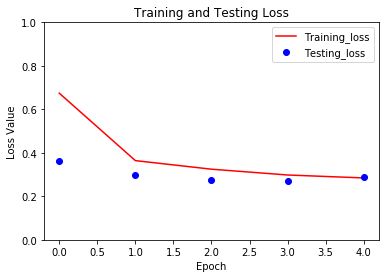

In [31]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, train_loss, 'r', label = 'Training_loss')
plt.plot(epochs, test_loss, 'bo', label = 'Testing_loss')
plt.title( 'Training and Testing Loss' )
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss Value' )
plt.ylim( [0,1] )
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


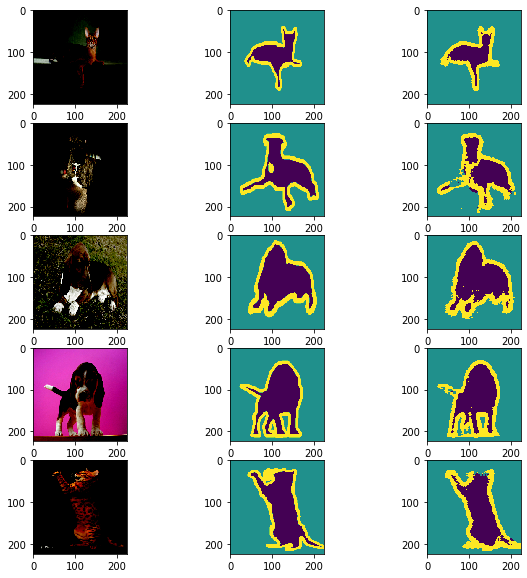

In [38]:
# 在测试数据上看效果：
num = 5 # 一次看5张效果！

for image, label_real in test_dataset.take(1):
    label_pred = model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！变成(224,224)
    
    plt.figure( figsize=(10,10) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( image[i] )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(224,224) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy() )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


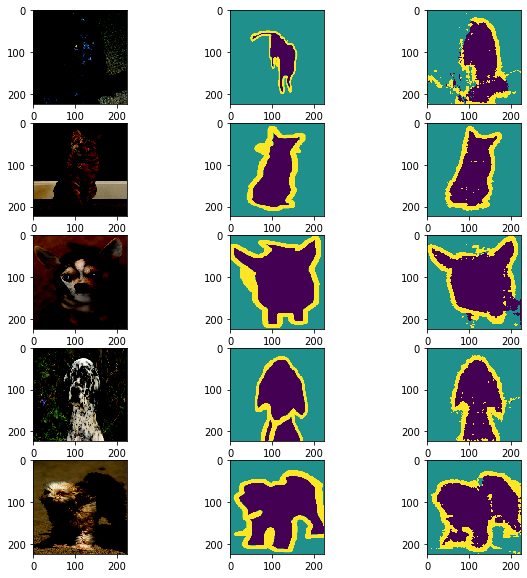

In [37]:
# 在实际数据上看效果：
num = 5 # 一次看5张效果！

for image, label_real in train_dataset.take(1):
    label_pred = model.predict(image)
    label_pred = tf.argmax( label_pred, axis = -1 )  # 每个维度上，取一个最大值！变成(224,224)
    
    plt.figure( figsize=(10,10) )
    # 每行3张图，从左到右：原图、真实标签图、预测标签图
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow( image[i] )
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow( label_real[i].numpy().reshape(224,224) )
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow( label_pred[i].numpy() )